In [1]:
import scipy.io as spio
import scipy.stats as stats
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

### 11 server features (server features unknown)

#### Two data sets:
1. 100 samples of labeled data (inlier or outlier) with 10 outliers which is used to compute anomalie threshold.
2. 1000 samples of unlabeled data which we'll use to predict anomalies.

(1000, 11)


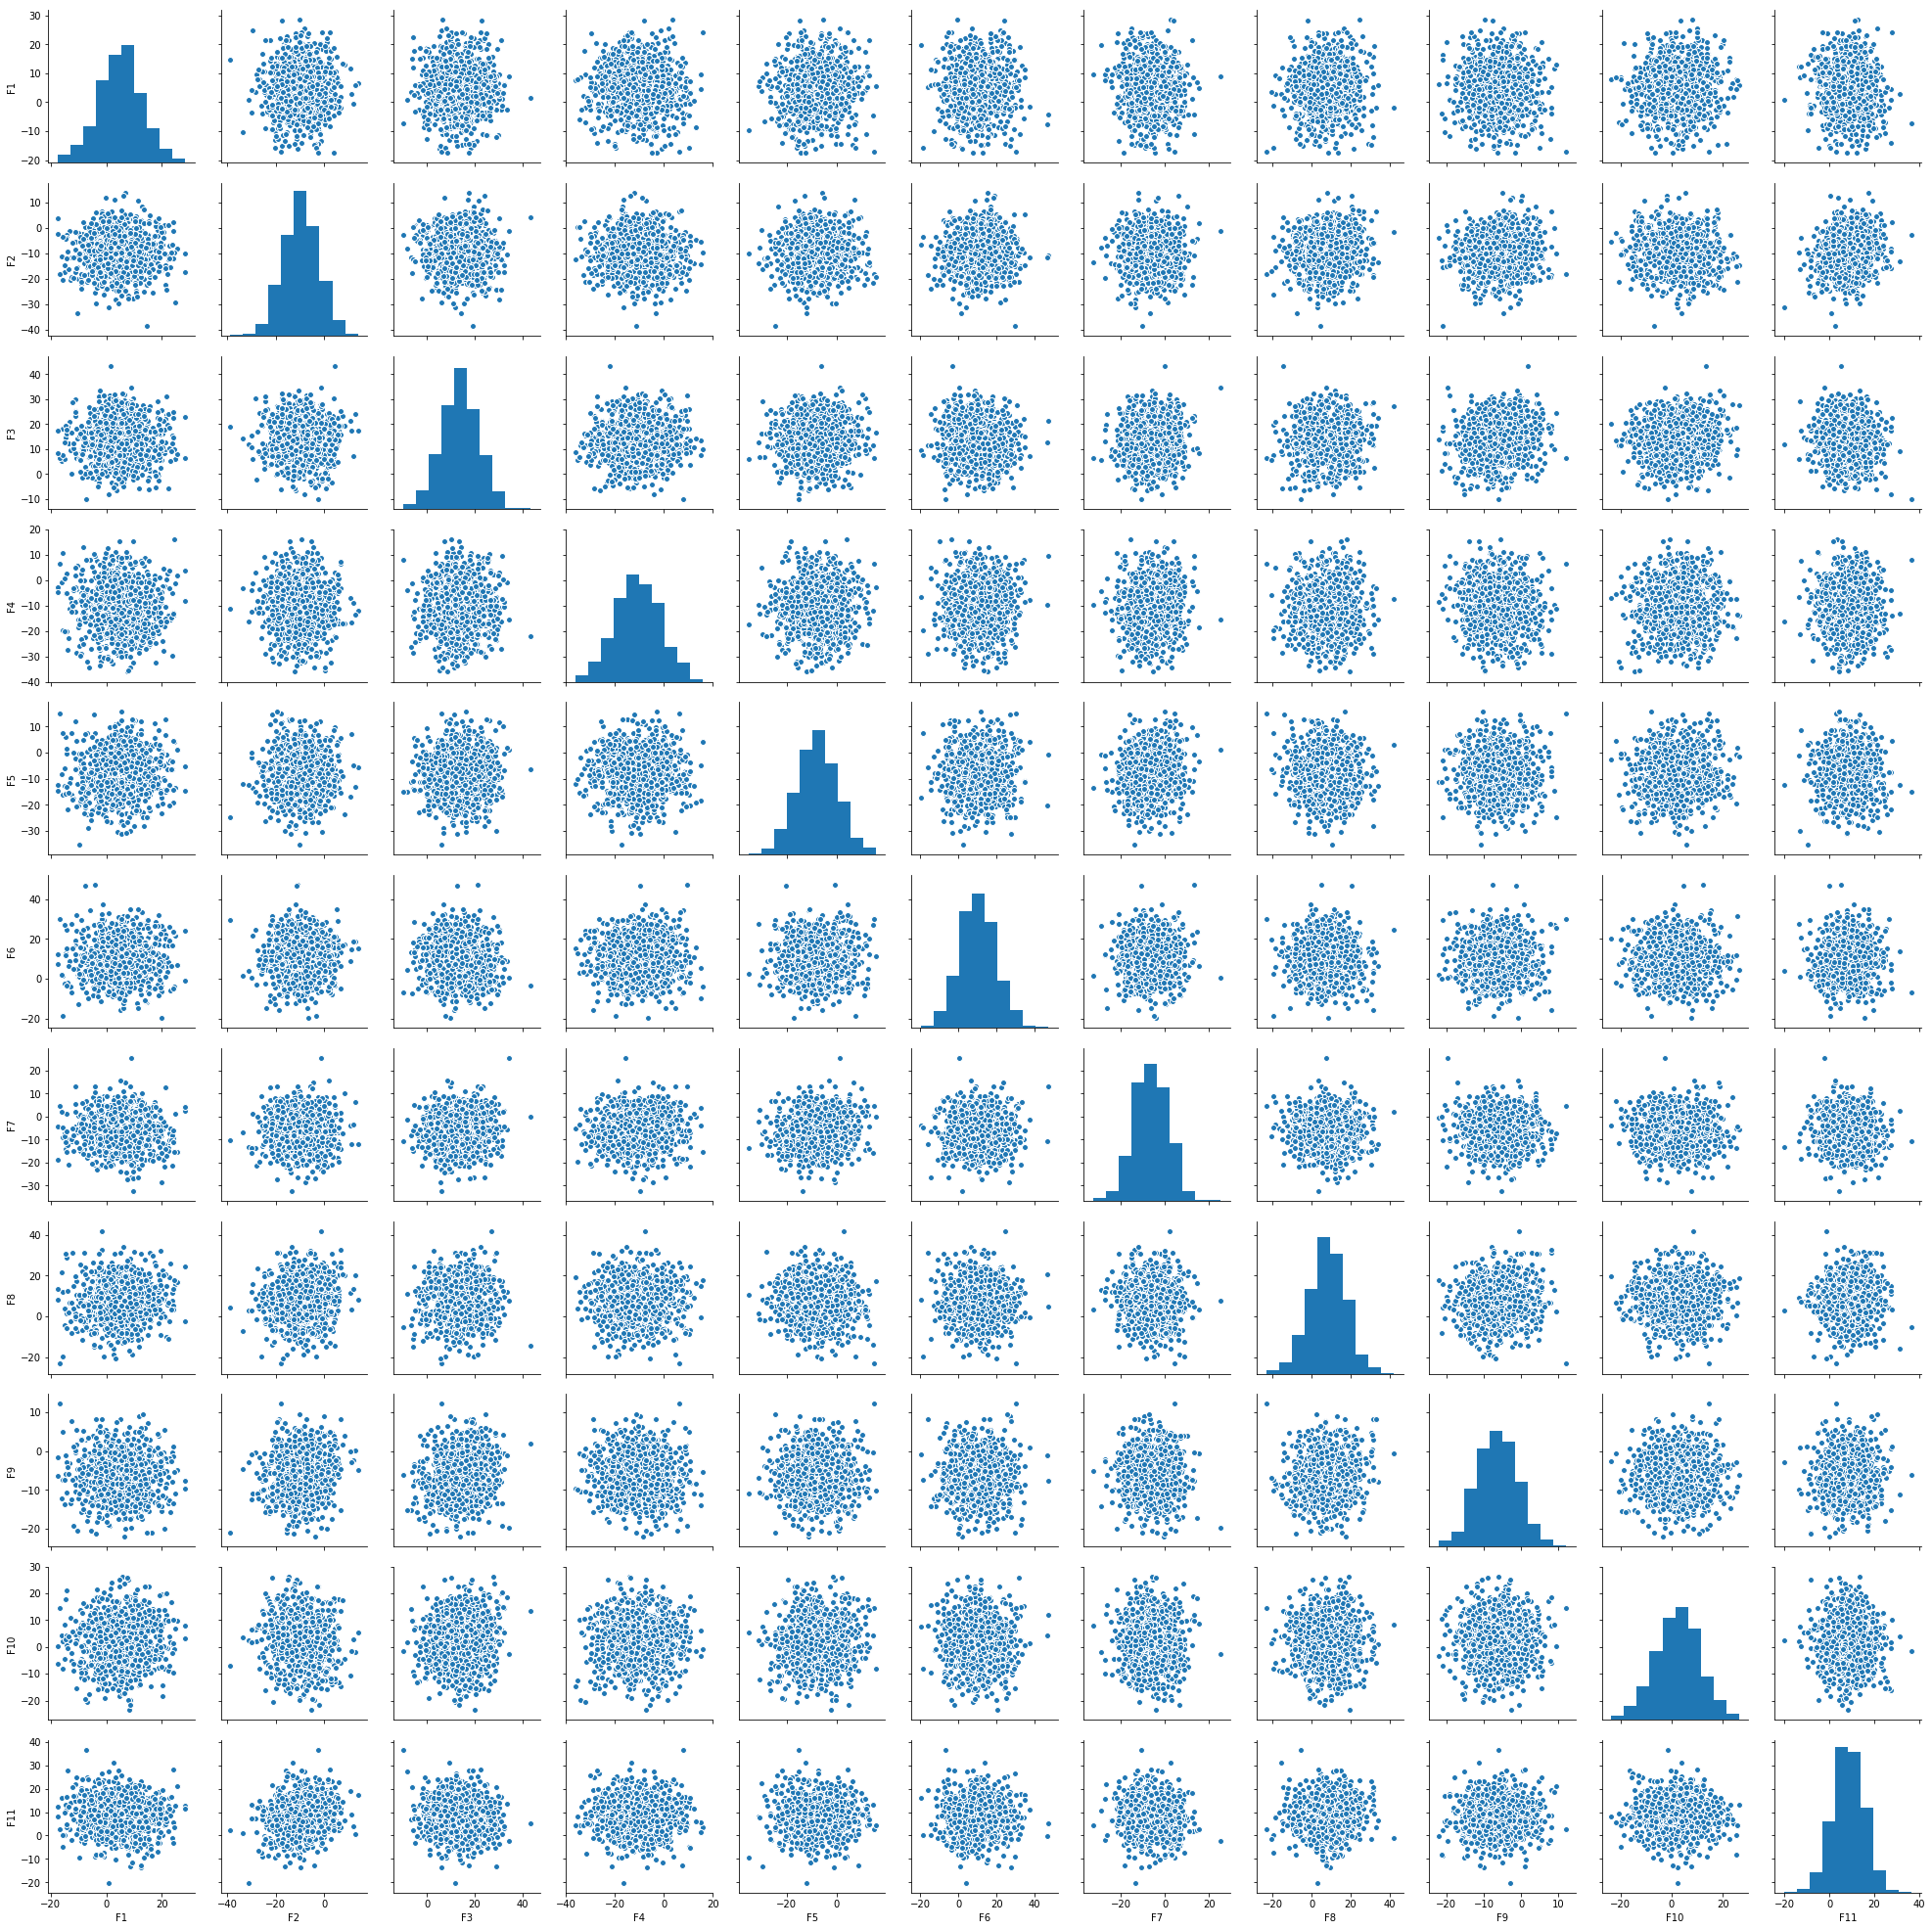

In [2]:
mat_data = spio.loadmat('../data/larger_data_set.mat')
# The data set consists of 1000 observations. Each sample has 11 features.
X = mat_data.get('X')
print(X.shape)
type(X)
dataframe = pd.DataFrame(X,columns='F1 F2 F3 F4 F5 F6 F7 F8 F9 F10 F11'.split())
sns.pairplot(dataframe)

#### Compute gaussian estimate parameters

In [3]:
x_transpose = np.transpose(X)
# mean
mu = np.mean(x_transpose, axis=1)

# covariance
sigma = np.cov(x_transpose, bias=True)

# Outstanding question on why the results are better if only the variances are used from the covariance matrix
p = multivariate_normal.pdf(X, mu, sigma.diagonal())

#### Read the cross validation samples to compute threshold values

In [4]:
# The cross validation data has 100 samples with 10 outliers.
x_cross_validation = mat_data.get('Xval')
y_val = mat_data.get('yval')
y_val = np.reshape(y_val, y_val.shape[0])
p_val = multivariate_normal.pdf(x_cross_validation, mu, sigma.diagonal())

#### Threshold algorithm

In [5]:
def select_threshold(y_val, p_val):
    
    def compute_precision(true_positives, false_positives):
        if (true_positives + false_positives) != 0:
            precision = true_positives/(true_positives + false_positives)
        else:
            precision = 0
        return precision

    def compute_recall(true_positives, false_negatives):
        if (true_positives + false_negatives) != 0:
            recall = true_positives/(true_positives + false_negatives)
        else:
            recall = 0
        return recall

    def compute_f1(precision, recall):
        if (precision + recall) != 0:
            f1 = 2 * precision * recall/(precision + recall)
        else:
            f1 = 0
        return f1

    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    best_f1_precision = 0
    best_f1_recall = 0
    p_min =  p_val.min()
    p_max = p_val.max()
    step_size = (p_val.max() - p_val.min())/ 1000

    epsilon= p_min
    while epsilon < p_max:
        predictions = p_val < epsilon
        false_positives = np.sum(np.logical_and((predictions == 1), (y_val == 0)))
        true_positives = np.sum(np.logical_and((predictions == 1), (y_val== 1)))
        false_negatives = np.sum(np.logical_and((predictions == 0), (y_val== 1)))
        precision = compute_precision(true_positives, false_positives)
        recall = compute_recall(true_positives, false_negatives)
        f1 = compute_f1(precision, recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_f1_recall = recall
            best_f1_precision = precision
            best_epsilon = epsilon

        epsilon = epsilon + step_size

    return best_epsilon, best_f1, best_f1_recall, best_f1_precision

In [6]:
(epsilon, f1, recall, precision) = select_threshold(y_val, p_val)
print("epsilon= ", epsilon)
print("f1= ", f1)
print("precision= ", precision)
print("recall= ", recall)
outliers = np.where(p < epsilon)
print("Number of outliers found:  " + repr(outliers[0].size))

epsilon=  1.3772288907613504e-18
f1=  0.6153846153846154
precision=  0.5
recall=  0.8
Number of outliers found:  117
